# Multirotor trajectory optimization with openmdao and FMU

In [1]:
import os.path as pth
import numpy as np
import matplotlib.pyplot as plt
import openmdao.api as om

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


In [2]:
# Loading the different FMUs

from pyfmi import load_fmu

ressources_folder = "../ressources"
speed_model_file_name = "DroneFMU.DroneOptim_Speed.fmu"
torque_model_file_name = "DroneFMU.DroneOptim_Torque.fmu"

speed_file_path = pth.join(ressources_folder, speed_model_file_name)
torque_file_path = pth.join(ressources_folder, torque_model_file_name)

#Load the FMU
speed_model = load_fmu(speed_file_path) # Model
torque_model = load_fmu(torque_file_path) # Model

## Running the model

In [11]:
from trajectory import Model, plot_trajectory

num_points = 20
num_simu_points = 500
final_time = 5.
use_torque = True
model = torque_model

# Initial torque
torque = np.linspace(0.06, 0.06, num=num_points)

prob = om.Problem()
prob.model = Model(
                num_points=num_points,
                num_simu_points=num_simu_points,
                final_time=final_time,
                use_torque=use_torque,
                model=model,
)

prob.setup(check=True)

prob["torque"] = torque

prob.run_model()

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.026598900000010417 seconds.


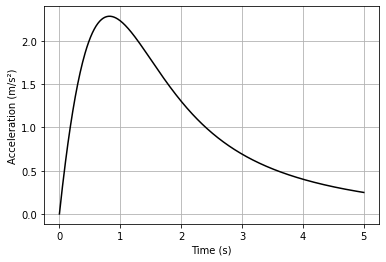

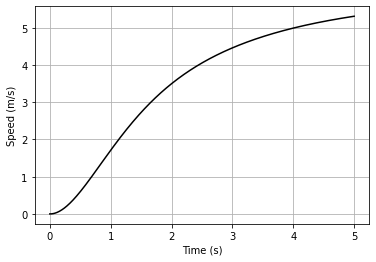

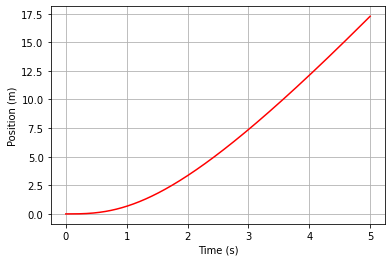

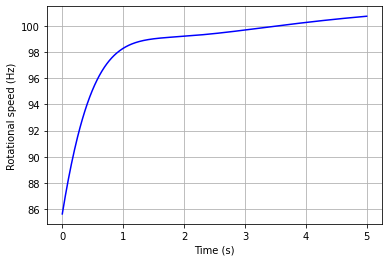

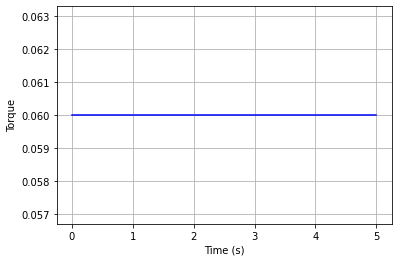

No handles with labels found to put in legend.


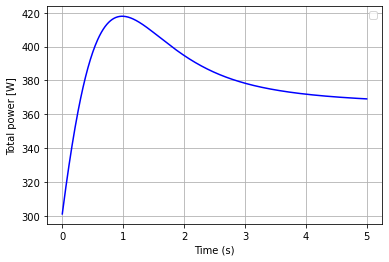

In [4]:
plot_trajectory(prob.model.trajectory.res)

## Run an optimization

In [12]:
from trajectory import Model, plot_trajectory

num_points = 100
num_simu_points = 500
final_time = 5.
use_torque = True
model = torque_model

# Hover torque
T_hov = 0.04214243*1.2

# Initial torque
torque = np.linspace(T_hov, T_hov, num=num_points)

prob = om.Problem()

prob.model = Model(
                num_points=num_points,
                num_simu_points=num_simu_points,
                final_time=final_time,
                use_torque=use_torque,
                model=model,
)

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1e-8
prob.driver.options['maxiter'] = 200
prob.model.add_design_var('torque', lower=T_hov*0.1, upper=T_hov*2.)
prob.model.add_design_var('final_time', lower=2., upper=10.)
# prob.model.add_constraint('acc_capacity', lower=0.0)
prob.model.add_constraint('final_speed', lower=0., upper=0.0)
prob.model.add_constraint('final_position', lower=10., scaler=1e-1)
# prob.model.add_objective('total_energy', ref0=100., ref=20000.)
prob.model.add_objective('total_energy', scaler=1e-3)

prob.setup(check=True)

prob["torque"] = torque
prob["final_time"] = final_time

prob.run_driver()
print("Total energy : ", prob["total_energy"])

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.03302600000000666 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.03398999999996022 seconds.
Simulation interval    : 0.0 - 5.000001 seconds.
Elapsed simulation time: 0.024395499999968706 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.01876559999999472 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018257599999969898 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.01844279999994569 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018999399999984234 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018492600000001858 seconds.
Simulat

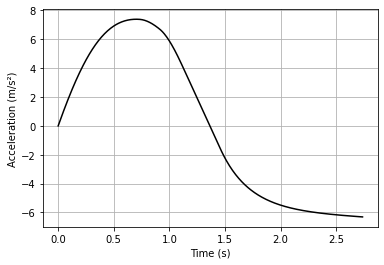

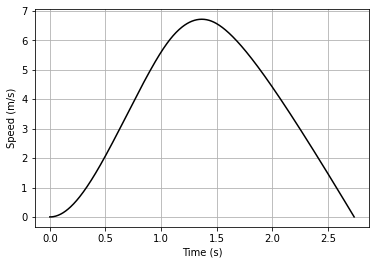

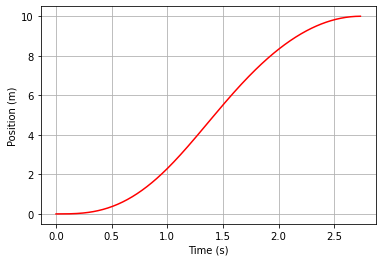

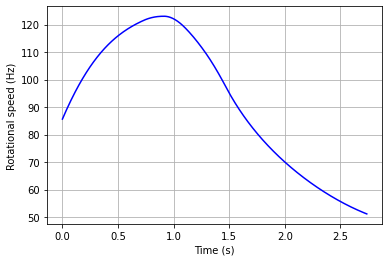

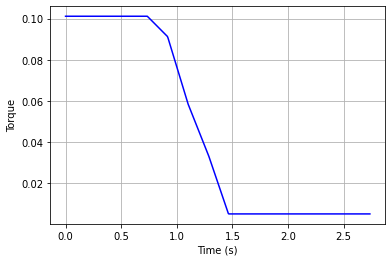

No handles with labels found to put in legend.


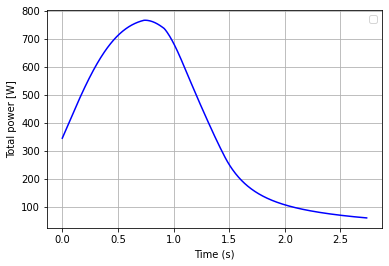

In [9]:
plot_trajectory(prob.model.trajectory.res)